
#Maroua Hibatollah AABOUD


#A first analysis of the COMPAS dataset
## Dataset description


We will examine the ProPublica COMPAS dataset, which contains the records of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date). Finally, the dataset contains the risk of recidivism predicted by the COMPAS tool, and also information about whether the defendant did actually recidivate or not (ground truth label for us).

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially an estimate of the likelihood of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

Some of the code below is adapted from the Propublica github repository above, and from

https://investigate.ai/propublica-criminal-sentencing/week-5-1-machine-bias-class/

## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis

In [76]:
%matplotlib inline

import urllib.request
import os,sys
import numpy as np
import pandas as pd
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")

COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


## Loading and cleaning data

The following code load the data using pandas and cleans it according to ProPublica's cleaning:

"
If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.

We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.

In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed

We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility."
"

Finally, it converts the data to a dictionary with np arrays, which will be useful later

In [77]:
# load the file
df = pd.read_csv(COMPAS_INPUT_FILE)


df = df.dropna(subset=["days_b_screening_arrest"])

df = df[
    (df.days_b_screening_arrest <= 30) &
    (df.days_b_screening_arrest >= -30) &
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True)



data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])

df1 = df
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
6168,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
6169,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
6170,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## Exploring the dataset

The following pandas commands are very convenient to explore the data. Uncomment them to explore the data.

<span style="color:red">TODO</span>: Add a command to print the number of defendents per race.

In the following, the majority are  African-Americans and Caucasians(termed blacks and whites for short)

In [78]:

df.race.value_counts() # number of people by race


race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

**COMMENT**
we can notice that the difference of number of population between groups are so huge.

African-American    3175

Caucasian           2103

Hispanic             509

Other                343

Asian                 31

Native American       11

## Basic analysis of the bias in COMPAS scores

We now look at the COMPAS scores (deciles first, then text scores) as a function of the sensitive attribute (race or gender) to observe potential differences.

We start by observing the scores for different groupes.


<Axes: title={'center': "Caucasian Defendant's Decile Scores "}, ylabel='Frequency'>

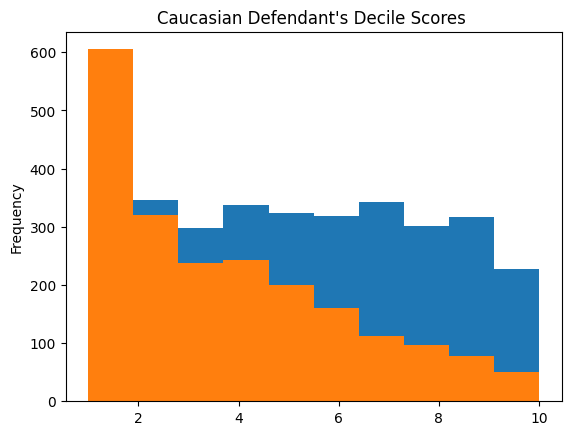

In [79]:
df[df.race == 'African-American']['decile_score'].plot(kind='hist', title='African-American Defendant\'s Decile Scores ')
df[df.race == 'Caucasian']['decile_score'].plot(kind='hist', title='Caucasian Defendant\'s Decile Scores ')


The  observation can be explained by a dependence between the race and true label.

In [80]:
# recidivism rates by race
recid_race = pd.crosstab(df.race, df.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.523150
Asian,23,8,0.258065
Caucasian,1281,822,0.390870
Hispanic,320,189,0.371316
Native American,6,5,0.454545
Other,219,124,0.361516


We now look at whether we observe a similar phenomenon on the text scores of COMPAS (low, medium, high risk).

In [81]:
# high risk rates by race
score_race = pd.crosstab(df.race, df.score_text)
score_race['High risk rate'] = score_race['High'] / score_race.sum(axis=1)
score_race

score_text,High,Low,Medium,High risk rate
race,,,,
African-American,845,1346,984,0.266142
Asian,3,24,4,0.096774
Caucasian,223,1407,473,0.106039
Hispanic,47,368,94,0.092338
Native American,4,3,4,0.363636
Other,22,273,48,0.064140


### Fairness metrics for the COMPAS scores

We do not have the actual scores that are used to compte text scores Low-Med-High; hence we cannot investigate directly the calibration. However, we can use the decile score as a proxy, and we can investigate PPV.

Let us first plot the probability of recidivism by decile score. We notice that it is not very far from a diagonale.

<Axes: xlabel='decile_score'>

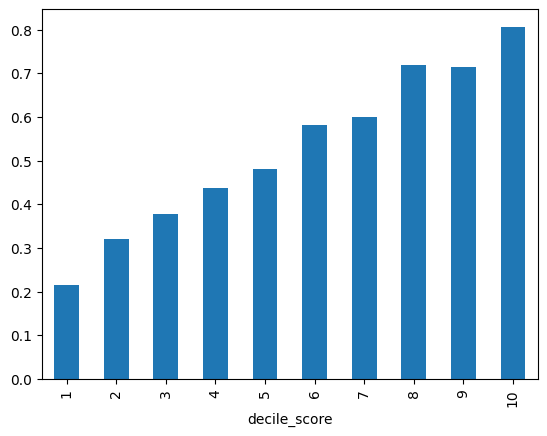

In [82]:
# probability of recidivism by decile
df.groupby(df.decile_score)['two_year_recid'].mean().plot(kind='bar')

<span style="color:red">TODO</span>: Plot a similar graph with separated bars for Blacks and Whites.

<Axes: xlabel='decile_score'>

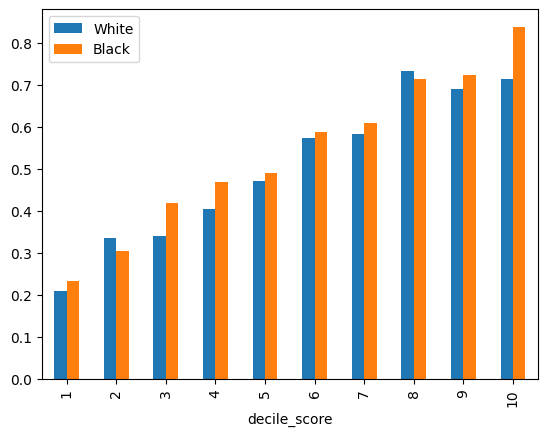

In [83]:
b = df[df.race=='African-American'].groupby(df.decile_score)['two_year_recid'].mean()
w = df[df.race!='African-American'].groupby(df.decile_score)['two_year_recid'].mean()
a = pd.concat([w,b], axis=1)
a.columns = ['White','Black']
a.plot.bar()
# -->

#COMMENT
we notice from this plot that there are mostly more black people than others

To further analyze the COMPAS score as a classifier, we transform it into a binary outcome by splitting "low" (class 0) from "medium or high" risk (class 1). We can then compute standard quantities such as the confusion matrix or PPV.

In [84]:
# COMPAS recidivism confusion matrix
df['guessed_recid'] = df.score_text != 'Low'
df['actual_recid'] = df.two_year_recid == 1
cm = pd.crosstab(df.actual_recid, df.guessed_recid)
cm # for "confusion matrix"

guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


We finally compute the PPV, TPR and FPR of the COMPAS classifier.

 Observe the differences in the metrics between Blacks and Whites and comment.

In [85]:
# cm is a confusion matrix. The rows are guessed, the columns are actual
def print_ppv_fpv(cm):
    TN = cm[False][False]
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    Accuracy  = (TN+TP)/(TN+TP+FN+FP)
    PPV= TP / (TP + FP)
    FPR= FP / (FP + TN)
    FNR= FN / (FN + TP)
    print('Accuracy: ', Accuracy)
    print()
    print('PPV: ', PPV)
    print('FPR: ', FPR)
    print('FNR: ', FNR)
    print()


def print_ppv_fpv_diff(cm1, cm2):
    print("-----------difference between groups----------")
    TN = cm1[False][False]
    TP = cm1[True][True]
    FN = cm1[True][False]
    FP = cm1[False][True]
    Accuracy  = (TN+TP)/(TN+TP+FN+FP)
    treatment = FP / FN
    PPV= TP / (TP + FP)
    FPR= FP / (FP + TN)
    FNR= FN / (FN + TP)

    TN1 = cm2[False][False]
    TP1 = cm2[True][True]
    FN1 = cm2[True][False]
    FP1 = cm2[False][True]
    Accuracy1  = (TN1+TP1)/(TN1+TP1+FN1+FP1)

    PPV1= TP1 / (TP1 + FP1)
    FPR1= FP1 / (FP1 + TN1)
    FNR1= FN1 / (FN1 + TP1)
    treatment1 = FP1 / FN1


    print('Accuracy: ', abs(Accuracy - Accuracy1))
    print("Treatment equality", abs(treatment1 - treatment))
    print('PPV difference: ', abs(PPV1 - PPV))
    print('FPR difference: ', abs(FPR1 - FPR))
    print('FNR difference: ', abs(FNR1 - FNR))
    print()



def print_metrics(b_guessed, b_actual, w_guessed, w_actual):
    b_cm = pd.crosstab(b_guessed, b_actual, rownames=['guessed'], colnames=['actual'])
    print("-----------black")
    print(b_cm)
    print_ppv_fpv(b_cm)
    w_cm = pd.crosstab(w_guessed, w_actual, rownames=['guessed'], colnames=['actual'])
    print("-----------white")
    print(w_cm)
    print()
    print_ppv_fpv(w_cm)
    print_ppv_fpv_diff(w_cm,b_cm)


Subset_w = df[df['race'] != 'African-American']
Subset_b = df[df.race == 'African-American']

acc = pd.crosstab(df.guessed_recid, df.actual_recid, rownames=['guessed'], colnames=['actual'])
print("COMPAS accuracy score")
print_ppv_fpv(acc)
print_metrics(Subset_b.guessed_recid, Subset_b.actual_recid, Subset_w.guessed_recid, Subset_w.actual_recid)





COMPAS accuracy score
Accuracy:  0.6607258587167855

PPV:  0.6299527444565612
FPR:  0.30270591733571217
FNR:  0.38305446778212887

-----------black
actual   False  True 
guessed              
False      873    473
True       641   1188
Accuracy:  0.6491338582677165

PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298

-----------white
actual   False  True 
guessed              
False     1472    603
True       377    545

Accuracy:  0.6730063396730064

PPV:  0.5911062906724512
FPR:  0.2038939967550027
FNR:  0.5252613240418118

-----------difference between groups----------
Accuracy:  0.023872481405289858
Treatment equality 0.7299724071678254
PPV difference:  0.05842897449977402
FPR difference:  0.21948777339030773
FNR difference:  0.240493112121282



Conclusion: the False Positive Rate is substantially higher for black defendants,This can seen by the FPR difference which is the difference between the two groups but the PPV is roughly similar between blacks and whites . the COMPAS score satisfies sufficiency, but not separation.

when the FFR between the two groups means that they are treated equally

#OTHER ANALYSIS

**COMMENT**
As Hispanic, Other, Asian, Native American represent the minority, we grouped these races in one group and the black race on another group to have two different groups that have basically the same number of population


-As we can see in the following graph black race is higher than other races

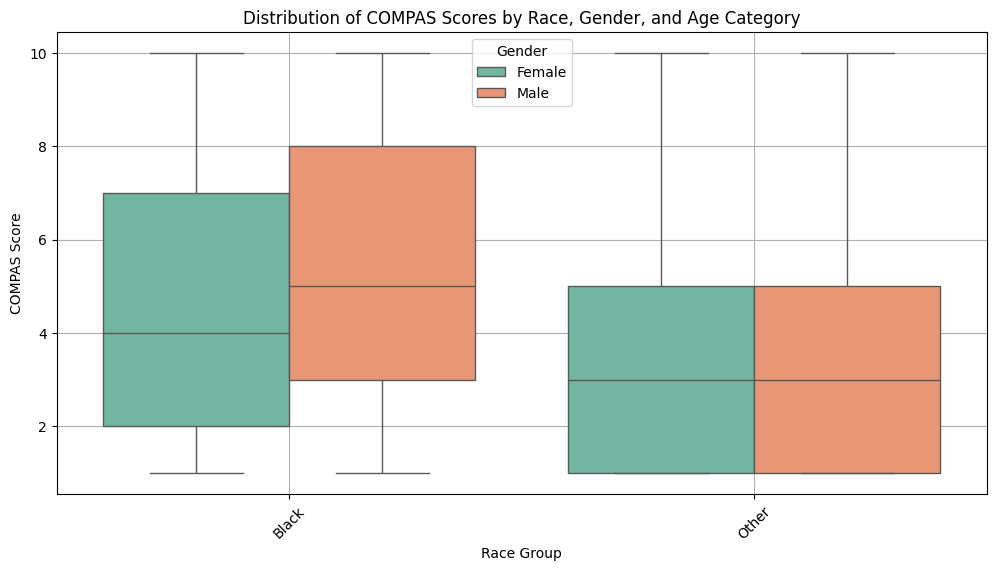

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df['race_group'] = df['race'].apply(lambda x: 'Black' if x == 'African-American' else 'Other')


plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='race_group', y='decile_score', hue='sex', palette='Set2',
            order=['Black', 'Other'], hue_order=['Female', 'Male'])
plt.title('Distribution of COMPAS Scores by Race, Gender, and Age Category')
plt.xlabel('Race Group')
plt.ylabel('COMPAS Score')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(True)
plt.show()


#Let's take a look at the COMPAS score by age and by race.

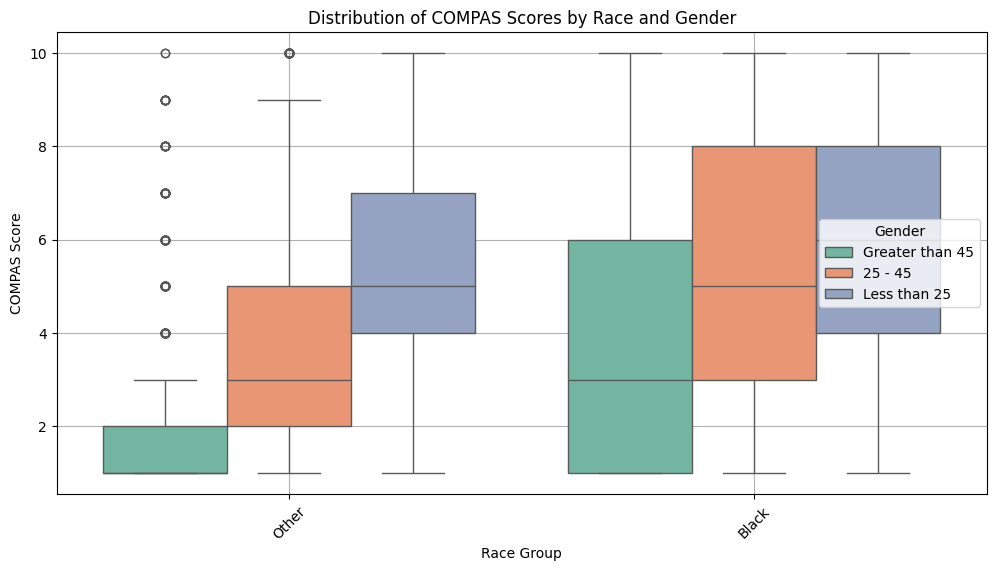

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

df['race_group'] = df['race'].apply(lambda x: 'Black' if x == 'African-American' else 'Other')


plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='race_group', y='decile_score', hue='age_cat', palette='Set2')
plt.title('Distribution of COMPAS Scores by Race and Gender')
plt.xlabel('Race Group')
plt.ylabel('COMPAS Score')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(True)
plt.show()

##COMMENT
We can see from this graph that there are more young black individuals likely to have a high score than other racial groups

#Another analysis:
As we can observe, the different racial groups do not have the same population size, so to make a fair comparison, we need to take a sample from each group to see if the black group is truly disadvantaged.

We randomly selected 10 individuals from each group for this analysis.
Let's see the results:

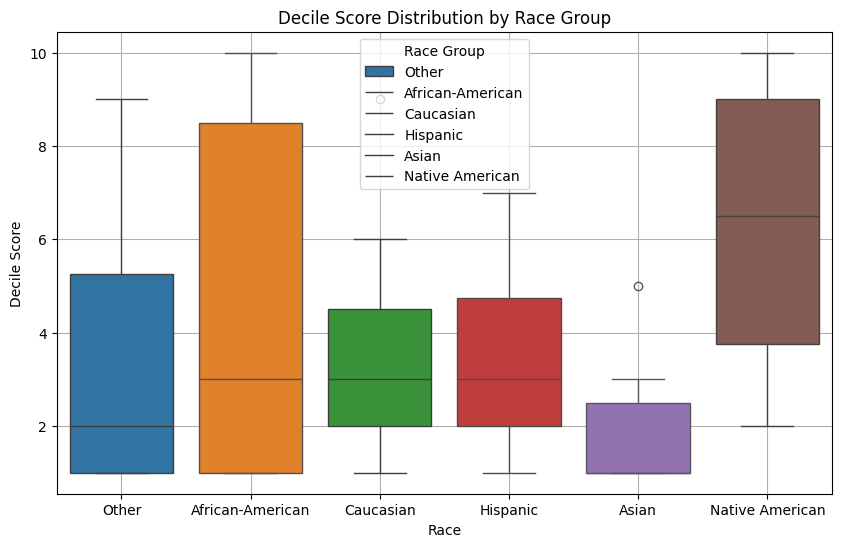

In [141]:
import seaborn as sns

race_groups = df1['race'].unique()
sampled_data_per_race = {}
num_samples_per_group = 10

for race_group in race_groups:
    indices = df1[df1['race'] == race_group].index
    if num_samples_per_group > len(indices):
        num_samples_per_group = len(indices)


    sampled_indices = np.random.choice(indices, size=num_samples_per_group, replace=False)


    sampled_data_per_race[race_group] = df1.loc[sampled_indices].copy()

plt.figure(figsize=(10, 6))

for race_group, sampled_data in sampled_data_per_race.items():  # Changed variable name here
    sns.boxplot(data=sampled_data, x='race', y='decile_score', ax=plt.gca())

plt.title('Decile Score Distribution by Race Group')
plt.xlabel('Race')
plt.ylabel('Decile Score')

plt.legend(sampled_data_per_race.keys(), title='Race Group')
plt.grid(True)
plt.show()


# COMMENT
Since the data is randomly sampled from the dataset, it's possible for the graph's analysis to change.
In 70% of cases, with each new execution of the cell, we notice that the decile scores of all other races are below average except for those of blacks. As for the case of Native Americans, 10 individuals represent 99.9% of the total population, so it's normal for the decile score to be high.

(we recommand you to execute the cell several time to see the difference)

## GENERAL COMMENT

The analyses highlight inequalities in how individuals are treated by COMPAS, indicating disparities between groups, especially among young blacks.

#STANDARD CLASSIFIER

## Training a classifier from the ground truth label

We now train a classifier (a simple logistic regression) on the label two_year_recid. We work on a subset of features: ["age_cat", "race", "sex", "priors_count", "c_charge_degree"].

<span style="color:red">TODO</span>: Complete the model definition and fitting.

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
CONT_VARIABLES = ["priors_count"]
CLASS_FEATURE = "two_year_recid"
SENSITIVE_ATTRS = ["race"]


y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0)
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals)
        vals = np.reshape(vals, (len(y), -1))

    else:
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)


    X = np.hstack((X, vals))



ind = data["race"]=="African-American"
X_b = X[ind]
y_b = y[ind]
ind = data["race"]!="African-American"
X_w = X[ind]
y_w = y[ind]
ind = [data["race"][i]!= "Caucasian" and data["race"][i] != "African-American" for i in range(len(y))]
X_n = X[ind]
y_n = y[ind]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3, random_state=9012)

X_train = np.vstack((X_train_b, X_train_w, X_train_n))
y_train = np.hstack((y_train_b, y_train_w, y_train_n))
X_test = np.vstack((X_test_b, X_test_w, X_test_n))
y_test = np.hstack((y_test_b, y_test_w, y_test_n))


model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression()

We can then compute the model accuracy. Compare to the COMPAS accuracy.

In [90]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6559849198868991


The accuracy doesn't show any revelant information about the inegality accross the group

We can also plot the ROC curve for the model on the global population.

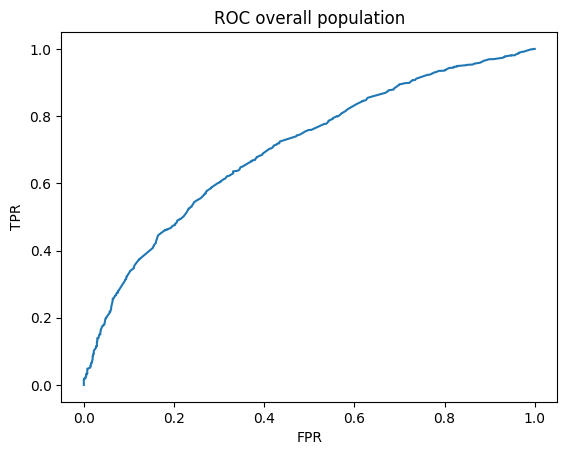

In [91]:
from sklearn import metrics
from matplotlib import pyplot as plt

scores = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores[:,1])

plt.plot(fpr, tpr)

plt.title('ROC overall population')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


let's Plot the ROC curve for Blacks and Whites in two separate curves (in the same plot)

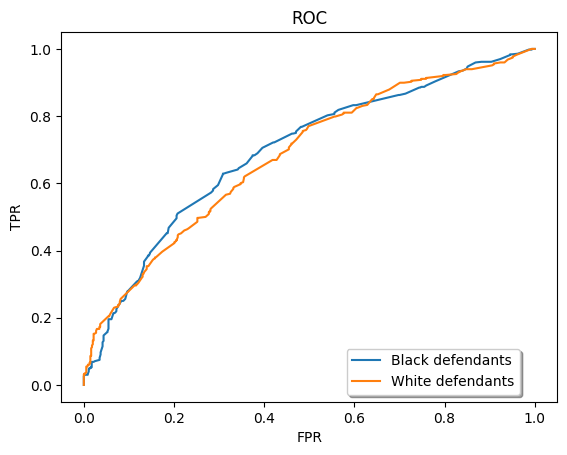

In [92]:
# TODO: Insert your code below this line
# <!--
scores = model.predict_proba(X_test_b)
fpr, tpr, thresholds_b = metrics.roc_curve(y_test_b, scores[:,1])
plt.plot(fpr, tpr, label='Black defendants')

scores = model.predict_proba(X_test_w)
fpr, tpr, thresholds_w = metrics.roc_curve(y_test_w, scores[:,1])
plt.plot(fpr, tpr, label='White defendants')

plt.title('ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)
plt.show()
# -->

##COMMENT

We observe that the Logistic Regression classifier produces a very similar ROC curve for both whites and blacks, and therefore seems to not be particularly biased.

**threshold choice**

We can finally check the fairness of this simple logistic regression, when choosing an arbitrary threshold common to the two groups.

 For choosing an appropriate threshold_common, we tested with different value,
 And we take the threshold_common with the bigger accuracy

 0.1 : 0.45223961144090663

 0.2 : 0.49487317862924984

 0.3 : 0.5693470048569886

 0.4 : 0.6475984889368591

 0.5 : 0.6540744738262277

 0.6 : 0.6330275229357798

 0.7 : 0.6011872638963842

 0.8 : 0.5801403130059363

 0.9 : 0.5639503507825149

 So we take threshold_common = 0.5.
 But here we just look at the accuracy, we can also look at the FNP or FNP.



<span style="color:red">TODO</span>: Compute the predictions for a common threshold (threshold_common), then compute the PPV, TPR, FPR (you can use the print_metrics function from above). Comment.

In [93]:
threshold_common = 0.5

y_pred_b = (model.predict_proba(X_test_b)[:,1] >= threshold_common).astype(int)
y_pred_w = (model.predict_proba(X_test_w)[:,1] >= threshold_common).astype(int)
print("\nLOGISTIC REGRESSION METRICS")
#print('------------White--------------------------------')
print_metrics(y_pred_b.astype(bool), y_test_b.astype(bool),y_pred_w.astype(bool), y_test_w.astype(bool) )


print("----------------------------------------------------------------------------------\n")
print('COMPAS METRICS:')
#print('------------------white---------------------')
sub = df[df.race != 'African-American']
sub1 = df[df.race == 'African-American']
print_metrics(sub1.guessed_recid, sub1.actual_recid, sub.guessed_recid, sub.actual_recid)




LOGISTIC REGRESSION METRICS
-----------black
actual   False  True 
guessed              
False      300    176
True       157    320
Accuracy:  0.6505771248688352

PPV:  0.6708595387840671
FPR:  0.3435448577680525
FNR:  0.3548387096774194

-----------white
actual   False  True 
guessed              
False      475    225
True        77    123

Accuracy:  0.6644444444444444

PPV:  0.615
FPR:  0.13949275362318841
FNR:  0.646551724137931

-----------difference between groups----------
Accuracy:  0.01386731957560916
Treatment equality 0.5498232323232324
PPV difference:  0.05585953878406713
FPR difference:  0.20405210414486408
FNR difference:  0.2917130144605117

----------------------------------------------------------------------------------

COMPAS METRICS:
-----------black
actual   False  True 
guessed              
False      873    473
True       641   1188
Accuracy:  0.6491338582677165

PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298

-----------white
act

In [94]:
# RECAP of the different accuracy :

#                           Logistic Reg                   COMPAS               Differences <
# African American :        0.6506                        0.6491                0.015%
# Others :                  0.6644                        0.6730                0.24%


# RECAP of the different FPR :

#                           Logistic Reg                   COMPAS               Differences <
# African-American :        0.3435                        0.4234                7.99%
# Others :                  0.1395                        0.2039                6.43%



# RECAP of the different FNR :

#                           Logistic Reg                   COMPAS               Differences <
# African-American :        0.3548                        0.2848                7%
# Others :                  0.6466                        0.5253                12.12%




# we can see that in both classifier we have the same conclusion: the FPR for African-American is greater than the Others
# and the FNR for African-American is lower than the Others
# thus it's not not fair yet

#Other classifier

In [95]:
from sklearn import svm
svm_class = svm.SVC(gamma=0.001,  probability=True)

svm_class.fit(X_train, y_train)

svm_y_pred = svm_class.predict(X_test)
print('Accuracy:', accuracy_score(y_test, svm_y_pred))


svm_y_pred_b = (svm_class.predict_proba(X_test_b)[:,1] >= threshold_common).astype(int)
svm_y_pred_w = (svm_class.predict_proba(X_test_w)[:,1] >= threshold_common).astype(int)
print("\n SUPPORT VECTOR MACHINE")

print_metrics(svm_y_pred_b.astype(bool), y_test_b.astype(bool), svm_y_pred_w.astype(bool), y_test_w.astype(bool))



Accuracy: 0.61875589066918

 SUPPORT VECTOR MACHINE
-----------black
actual   False  True 
guessed              
False      345    231
True       112    265
Accuracy:  0.640083945435467

PPV:  0.7029177718832891
FPR:  0.24507658643326038
FNR:  0.4657258064516129

-----------white
actual   False  True 
guessed              
False      506    249
True        46     99

Accuracy:  0.6722222222222223

PPV:  0.6827586206896552
FPR:  0.08333333333333333
FNR:  0.7155172413793104

-----------difference between groups----------
Accuracy:  0.03213827678675529
Treatment equality 0.3001095290251917
PPV difference:  0.020159151193633873
FPR difference:  0.16174325309992704
FNR difference:  0.2497914349276975



In [96]:
# RECAP of the different accuracy :

#                             COMPAS                SVM
# African American :         0.6491               0.6422
# Others :                   0.6730               0.6926


# RECAP of the different FPR :

#                             COMPAS                SVM
# African-American :         0.4234               0.2495
# Others :                   0.2039               0.0937



# RECAP of the different FNR :

#                            COMPAS                SVM
# African-American :        0.2848               0.4577
# Others :                  0.5253               0.6653




#we still have the same observations with the Logistic Reg one

**TODO** COMPARE with COMPAS and comment

##Random forest Classifier

In [97]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
random_forest_model=RandomForestClassifier()
random_forest_model.fit(X_train,y_train)
y_pred=random_forest_model.predict(X_test)
print("Accuracy :",accuracy_score(y_test,y_pred))




Accuracy : 0.6597549481621112


In [98]:
rf_y_pred_b = (random_forest_model.predict_proba(X_test_b)[:,1] >= threshold_common).astype(int)
rf_y_pred_w = (random_forest_model.predict_proba(X_test_w)[:,1] >= threshold_common).astype(int)
print("\n RANDOM FOREST CLASSIFIER")
print("")

print_metrics(rf_y_pred_b.astype(bool), y_test_b.astype(bool), rf_y_pred_w.astype(bool), y_test_w.astype(bool))


 RANDOM FOREST CLASSIFIER

-----------black
actual   False  True 
guessed              
False      301    173
True       156    323
Accuracy:  0.6547743966421826

PPV:  0.6743215031315241
FPR:  0.3413566739606127
FNR:  0.3487903225806452

-----------white
actual   False  True 
guessed              
False      442    205
True       110    143

Accuracy:  0.65

PPV:  0.5652173913043478
FPR:  0.19927536231884058
FNR:  0.5890804597701149

-----------difference between groups----------
Accuracy:  0.004774396642182599
Treatment equality 0.3651487381925842
PPV difference:  0.10910411182717628
FPR difference:  0.14208131164177212
FNR difference:  0.24029013718946973



In [99]:
# RECAP of the different accuracy :

#                               COMPAS                        Random Forest
# African American :        0.6491                           0.6537
# Caucasian :               0.6730                           0.6577


# RECAP of the different FPR :

#                               COMPAS                        Random Forest
# African-American :        0.4234                           0.3435
# Caucasian :               0.2039                           0.1823



# RECAP of the different FNR :

#                             COMPAS                          Random Forest
# African-American :      0.2848                             0.3488
# Caucasian :             0.5253                             0.6102

#same Observations with the previous Classifiers

#GENERAL COMMENT

In [100]:
# RECAP of the different accuracy :

#                              Logistic Reg                   COMPAS               SVM               Random Forest               Differences <
# African American :        0.6506                        0.6491               0.6422               0.6537                    0.0111%
# Caucasian :               0.6644                        0.6730               0.6926               0.6577                    0.0149%


# RECAP of the different FPR :

#                              Logistic Reg                   COMPAS               SVM               Random Forest               Differences <
# African-American :        0.3435                        0.4234               0.2495               0.3435                      0.0%
# Caucasian :               0.1395                        0.2039               0.0937               0.1823                    0.0428%



# RECAP of the different FNR :

#                              Logistic Reg                   COMPAS               SVM               Random Forest               Differences <
# African-American :        0.3548                        0.2848               0.4577               0.3488                    0.006%
# Caucasian :               0.6466                        0.5253               0.6653               0.6102                    0.055%


#
#Accuracy Comparison: Among the classifiers, SVM shows the highest accuracy for both African American and Others groups,
#closely followed by Random Forest. However, the differences in accuracy between the classifiers are relatively small.

#False Positive Rate (FPR): Logistic Regression and Random Forest exhibit similar FPR values for African American groups,
#while SVM shows the lowest FPR. For Others groups, SVM has the lowest FPR, followed by Random Forest. COMPAS, however,
#has notably higher FPR values for both racial groups.

#False Negative Rate (FNR): Logistic Regression and Random Forest perform similarly in terms of FNR for both racial groups.
#COMPAS shows the lowest FNR for African American groups but the highest for Others groups. SVM exhibits the highest FNR for
#African-American groups.

#Fairness and Treatment Equality: While all classifiers show differences in fairness measures between racial groups, SVM demonstrates
#relatively better treatment equality compared to the other classifiers. Random Forest shows the least difference in fairness measures
#between racial groups wich is our goal.

# which Method would we recommend??


Based on the analysis of fairness measures across different machine learning models, we would recommend the Random Forest classifier. This recommendation is made because Random Forest showed the least difference in fairness measures between racial groups compared to other classifiers such as Logistic Regression and Support Vector Machine

#Which features will we use ??
**ANSWER**:

 Relevant Features: Choose features that are directly related to the prediction task and are known to have a legitimate impact on the outcome. For example, in predicting recidivism risk, features like prior criminal history, age, and offense type may be relevant.

Non-sensitive Features: Avoid using features that are closely associated with protected attributes such as race, gender. Using sensitive attributes directly can lead to biased predictions and unfair treatment of certain groups.

Balanced Representation: Ensure that the dataset used for training the classifier contains a balanced representation of different groups and demographics. Imbalanced datasets can lead to biased models, especially if one group is underrepresented for example Native-American.

#meaningful notion of fairness

- Statistical parity between different subgroups. The probability to be classified positive should be equal for the considered groups. Formula: (TP+FP)/total

- Equality of opportunity: similar members in each group should be treated similarly. Therefore, the two groups should have a similar TPR.
- Treatment Equality: For each group, the ratio between FP and FN should be equal. We use the ratio FP/FN, that means a low value represents a situation in which an individual is less likely to be classified false positive than false negative. This is something we want, as incorrectly classifying someone to be recidivist is undesirable.

# Fairness classifier

##Describe the different methods to obtain a fair classifier


**Pre-processing Techniques**: These methods involve modifying the dataset before training the classifier.

**In-processing Techniques**: These methods integrate fairness constraints directly into the model training process.

**Post-processing Techniques**: These methods adjust the output of a trained classifier to ensure fairness without retraining the model.


In the context of the COMPAS dataset, these methods could be applied to address biases in recidivism predictions based on race. For example:

Pre-processing techniques could be used to balance the dataset by adjusting the weights of instances or by oversampling and undersampling racial groups.

In-processing techniques could involve training a model with fairness constraints to ensure that predictions are equally accurate across different racial groups.

Post-processing techniques could adjust decision thresholds or incorporate a reject option to ensure fairness in classification outcomes.

#FAIR CLASSIFIER IMPLEMENTATION

We tried to implement a fair classifier with all method but at each tentative like demographic parity, ExponetielGradient, equalizedOdds, there are error in our implementation. the only one that we didn't expect to work is the one that works and satisfies the fairness notion.

**we decide to use the method of Post-proccessing to try to implement a fair classifier**

Threshold adjustement
We read on the internet regading the Compas project, that using different thresholds could lead to better fairness. Therefore, we decided to assign a separate threshold to each group and to use Random Forest Classifier since it gave us a good performance compred to Logistic regression and SVM.

In [139]:
target = df.two_year_recid

Rf = RandomForestClassifier()

Rf.fit(X_train,y_train)

y_pred = Rf.predict(X_test)

guessed = pd.Series(y_pred)==1

actual = target ==1

proba = Rf.predict_proba(X_test)[:,1]

guess = pd.Series(proba > 0.495)

guessed = guess.loc[df.race=='African-American'] = pd.Series(proba > 0.57)

subset1 = df.race != 'Caucasian'

subset = df.race == 'African-American'

print("------------------------Implemented Fair Classifier")

print_metrics(guessed[subset], actual[subset],guessed[subset1], actual[subset1])

------------------------Implemented Fair Classifier
-----------black
actual   False  True 
guessed              
False      311    308
True       163    150
Accuracy:  0.4946351931330472

PPV:  0.4792332268370607
FPR:  0.3438818565400844
FNR:  0.6724890829694323

-----------white
actual   False  True 
guessed              
False      446    365
True       228    186

Accuracy:  0.5159183673469387

PPV:  0.4492753623188406
FPR:  0.33827893175074186
FNR:  0.662431941923775

-----------difference between groups----------
Accuracy:  0.02128317421389153
Treatment equality 0.09543675502579607
PPV difference:  0.029957864518220134
FPR difference:  0.005602924789342545
FNR difference:  0.010057141045657358



#COMMENT

From these results, we can see that the difference between the False Positive Rates (FPR) and the False Negative Rates (FNR) of the different groups is almost negligible. This suggests that the classifier is almost fair.

#COMPAS Score

In [105]:
print("--------------------------COMPAS---------------------------")
print_metrics(Subset_b.guessed_recid, Subset_b.actual_recid, Subset_w.guessed_recid, Subset_w.actual_recid)


--------------------------COMPAS---------------------------
-----------black
actual   False  True 
guessed              
False      873    473
True       641   1188
Accuracy:  0.6491338582677165

PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298

-----------white
actual   False  True 
guessed              
False     1472    603
True       377    545

Accuracy:  0.6730063396730064

PPV:  0.5911062906724512
FPR:  0.2038939967550027
FNR:  0.5252613240418118

-----------difference between groups----------
Accuracy:  0.023872481405289858
Treatment equality 0.7299724071678254
PPV difference:  0.05842897449977402
FPR difference:  0.21948777339030773
FNR difference:  0.240493112121282



# COMPARAISON between COMPAS Score and Implemented fair clasiifier




In [140]:
#                                            COMPAS Score                                                     Implemented Fair Classifier

#                               Accuracy       PPV         FPR          FNR                                Accuracy       PPV       FPR        FNR

#  Black group                   0.6491       0.6495      0.4233       0.284                                0.494       0.479     0.343      0.672

#  White group                   0.6730       0.5911      0.2038       0.525                                0.515       0.449     0.338       0.662

#
#Difference                       0.0238       0.058      0.219       0.240                                 0.0075      0.0430    0.0077     0.0032

#Treatment equality                   0.7299724071678254                                                                     0.09543675502579607


#In conclusion, the fair classifier has effectively equalized the False Positive Rate (FPR) and False Negative Rate (FNR) for both racial groups. However, this improvement in fairness
# comes at the cost of reduced accuracy compared to the COMPAS classifier for both groups.
#While the fair classifier exhibits better parity in treatment across racial groups, there is a notable decrease in overall predictive performance. This trade-off suggests that further
#refinement is necessary to balance fairness and accuracy. Given more time, additional efforts could focus on optimizing the classifier to improve accuracy while maintaining equal treatment
#between groups.
